1. Importing the library and loading the model

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from roboticstoolbox import DHRobot, RevoluteDH, jtraj
from spatialmath import SE3
from scipy.interpolate import CubicSpline
import matplotlib.animation as animation

2. Creating an UR3 model with dynamic parameters

UR3 Link Parameters (standard configuration)

In [9]:
mm = 0.001
def create_ur3_robot():
    L = [
        RevoluteDH(d=151.9*mm, a=0, alpha=pi/2, m=3.8, r=[0, 0, 0.1363], I=[0.010267, 0.010267, 0.00666, 0, 0, 0], Jm=0.0004, B=0.0015, Tc=[0.395, -0.435], G=-62.6111, qlim=[-2*pi, 2*pi]),
        RevoluteDH(d=0, a=-243.65*mm, alpha=0, m=8.393, r=[0.2125, 0, 0], I=[0.22689, 0.22689, 0.0151074, 0, 0, 0], Jm=0.0004, B=0.000817, Tc=[0.126, -0.071], G=107.815, qlim=[-2*pi, 2*pi]),
        RevoluteDH(d=0, a=-213.25*mm, alpha=0, m=2.275, r=[0.15, 0, 0], I=[0.0494433, 0.0494433, 0.004095, 0, 0, 0], Jm=0.0004, B=0.00138, Tc=[0.132, -0.105], G=-53.7063, qlim=[-2*pi, 2*pi]),
        RevoluteDH(d=112.35*mm, a=0, alpha=pi/2, m=1.219, r=[0, 0.018, 0], I=[0.111172, 0.111172, 0.21942, 0, 0, 0], Jm=0.000033, B=0.0000712, Tc=[0.0112, -0.0169], G=76.0364, qlim=[-2*pi, 2*pi]),
        RevoluteDH(d=85.35*mm, a=0, alpha=-pi/2, m=1.219, r=[0, 0, 0.032], I=[0.111172, 0.111172, 0.21942, 0, 0, 0], Jm=0.000033, B=0.0000826, Tc=[0.00926, -0.0145], G=71.923, qlim=[-2*pi, 2*pi]),
        RevoluteDH(d=81.9*mm, a=0, alpha=0, m=0.1879, r=[0, 0, 0.032], I=[0.017136, 0.017136, 0.033822, 0, 0, 0], Jm=0.000033, B=0.0000367, Tc=[0.00396, -0.0105], G=76.686, qlim=[-2*pi, 2*pi])
    ]
    return DHRobot(L, name='UR3')

In [10]:
robot = create_ur3_robot()
print(robot)

DHRobot: UR3, 6 joints (RRRRRR), dynamics, standard DH parameters
┌─────┬─────────┬─────────┬────────┬─────────┬────────┐
│ θⱼ  │   dⱼ    │   aⱼ    │   ⍺ⱼ   │   q⁻    │   q⁺   │
├─────┼─────────┼─────────┼────────┼─────────┼────────┤
│  q1 │  0.1519 │       0 │  90.0° │ -360.0° │ 360.0° │
│  q2 │       0 │ -0.2437 │   0.0° │ -360.0° │ 360.0° │
│  q3 │       0 │ -0.2132 │   0.0° │ -360.0° │ 360.0° │
│  q4 │  0.1123 │       0 │  90.0° │ -360.0° │ 360.0° │
│  q5 │ 0.08535 │       0 │ -90.0° │ -360.0° │ 360.0° │
│  q6 │  0.0819 │       0 │   0.0° │ -360.0° │ 360.0° │
└─────┴─────────┴─────────┴────────┴─────────┴────────┘

┌──┬──┐
└──┴──┘



3. Setting the trajectory whith with different methods

In [11]:
q_start = np.zeros(6)
q_goal = np.array([pi/2, -pi/3, pi/3, pi/4, -pi/4, 0])

METHOD 1: jtraj (polynomial interpolation)

In [12]:
traj_jtraj = jtraj(q_start, q_goal, 100)

METHOD 2: Cubic Joint Spline

In [21]:
def cubic_spline_traj(q_start, q_goal, n_points=100):
    t = np.linspace(0, 1, 2)
    qs = np.vstack([q_start, q_goal])
    spline = CubicSpline(t, qs, axis=0)
    t_new = np.linspace(0, 1, n_points)
    q_traj = spline(t_new)
    qd_traj = spline(t_new, 1)
    qdd_traj = spline(t_new, 2)
    class Traj: 
        def __init__(self, q, qd=None, qdd=None):
            self.q = q
            self.qd = qd
            self.qdd = qdd
        def __len__(self):
            return len(self.q)
    return Traj(q_traj, qd_traj, qdd_traj)

traj_spline = cubic_spline_traj(q_start, q_goal, 100)

METHOD 3: Linear joint interpolation

In [28]:
class Traj:
    def __init__(self, q, qd=None, qdd=None):
        self.q = q
        self.qd = qd
        self.qdd = qdd
    
    def __len__(self):
        return len(self.q)

def linear_traj(q_start, q_goal, n_points=100):
    q_traj = np.linspace(q_start, q_goal, n_points)
    qd_traj = np.gradient(q_traj, axis=0)
    qdd_traj = np.gradient(qd_traj, axis=0)
    return Traj(q_traj, qd_traj, qdd_traj)

traj_linear = linear_traj(q_start, q_goal, 100)

4. Implementation regulation based on impedance control.

In [29]:
Kp = np.diag([120, 100, 80, 60, 40, 20]) # Жёсткость (пружины)
Kd = np.diag([35, 30, 25, 20, 15, 10]) # Демпфирование

def impedance_control(robot, q, qd, q_des, qd_des, qdd_des):
    e = q_des - q
    ed = qd_des - qd
    M = robot.inertia(q)
    C = robot.coriolis(q, qd)
    G = robot.gravload(q)
    # Импедансное управление
    tau = M @ (qdd_des + Kd @ ed + Kp @ e) + C @ qd + G
    return tau

5. Simulation of the system

In [50]:
def simulate(robot, traj, total_time=1.0):
    """
    Simulation of trajectory movement with time normalization.
    :param robot: robot object
    ::param traj: Traj object (with attributes q, qd, qd)
    :param total_time: total movement time (sec)
    ::return: q_ist, qd_hist, tsu_hist
    """
    n_points = len(traj)
    # Normalized time vector
    time_normalized = np.linspace(0, 1, n_points)
    # Time step so that the entire trajectory fits into total_time
    dt = total_time / (n_points - 1)
    
    q = traj.q[0].copy()
    qd = traj.qd[0].copy()
    q_hist, qd_hist, tau_hist = [q.copy()], [qd.copy()], []

    for i in range(1, n_points):
        q_des = traj.q[i]
        qd_des = traj.qd[i]
        qdd_des = traj.qdd[i]
        tau = impedance_control(robot, q, qd, q_des, qd_des, qdd_des)
        qdd = robot.accel(q, qd, tau)
        qd += qdd * dt
        q += qd * dt
        q_hist.append(q.copy())
        qd_hist.append(qd.copy())
        tau_hist.append(tau.copy())
    return np.array(q_hist), np.array(qd_hist), np.array(tau_hist)

6. Running a simulation for all methods

In [51]:
results = {}
for label, traj in [
    ('jtraj', traj_jtraj),
    ('CubicSpline', traj_spline),
    ('Linear', traj_linear)
]:
    # No-load simulation
    robot = create_ur3_robot()
    q_hist, qd_hist, tau_hist = simulate(robot, traj)
    
    # Simulation with a load of 2 kg
    robot_p = create_ur3_robot()
    robot_p.links[-1].m += 2  # Add mass to the last link
    q_hist_p, qd_hist_p, tau_hist_p = simulate(robot_p, traj)
    
    # Сохраняем оба набора данных
    results[label] = {
        'q': q_hist,         # No load
        'qd': qd_hist,
        'tau': tau_hist,
        'q_p': q_hist_p,     # With load
        'qd_p': qd_hist_p,
        'tau_p': tau_hist_p,
        'q_ref': traj.q
    }

7. Visualization

Comparison graphics

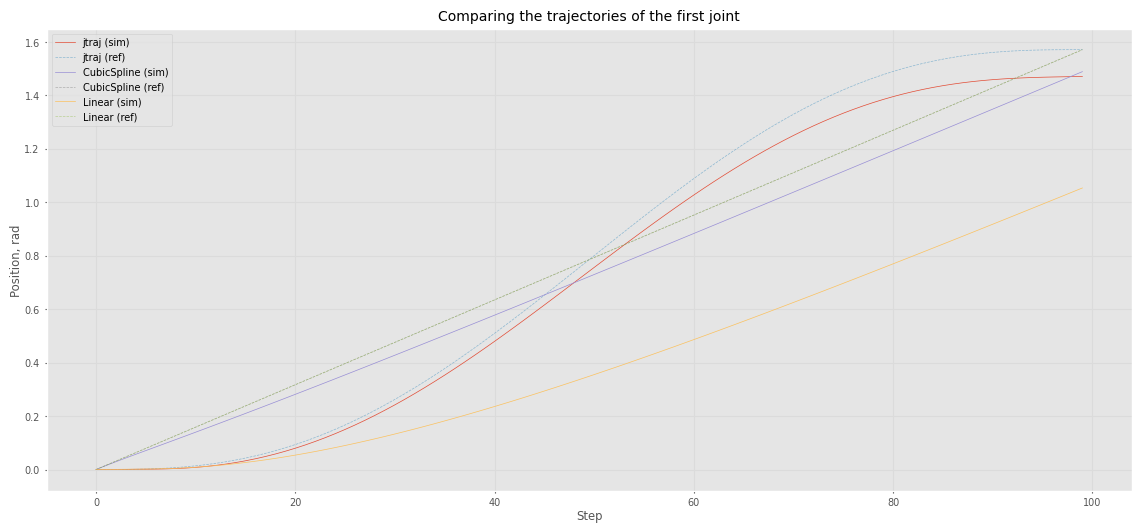

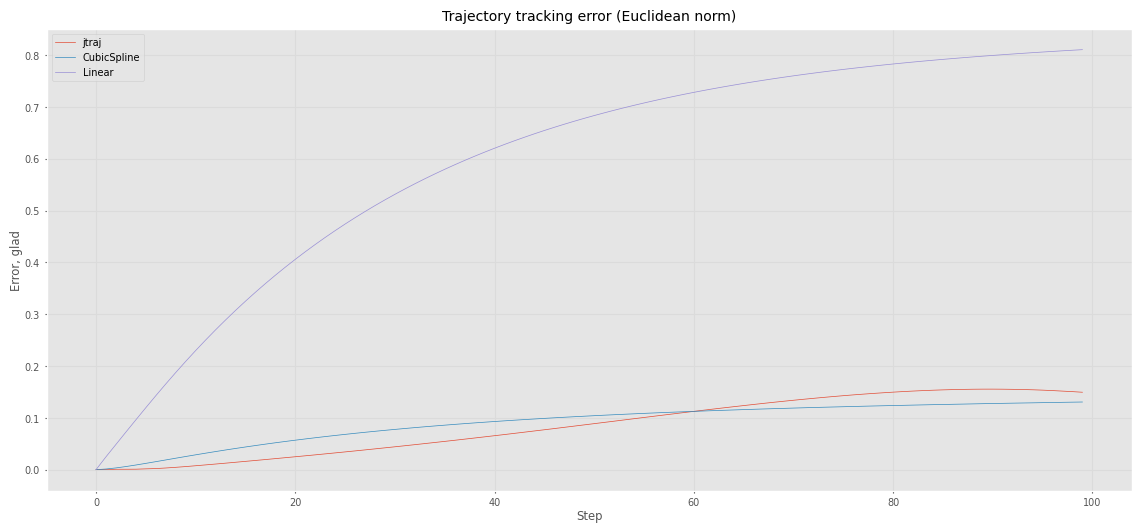

In [52]:

plt.figure(figsize=(14, 6))
for label, res in results.items():
    plt.plot(res['q'][:, 0], label=f'{label} (sim)')
    plt.plot(res['q_ref'][:, 0], '--', alpha=0.5, label=f'{label} (ref)')
plt.title('Comparing the trajectories of the first joint')
plt.xlabel('Step')
plt.ylabel('Position, rad')
plt.legend()
plt.show()

# Error graph by method 
plt.figure(figsize=(14, 6))
for label, res in results.items():
    err = np.linalg.norm(res['q'] - res['q_ref'], axis=1)
    plt.plot(err, label=label)
plt.title('Trajectory tracking error (Euclidean norm)')
plt.xlabel('Step')
plt.ylabel('Error, glad')
plt.legend()
plt.show()

Motion visualization and gif animation creation

In [55]:
def animate_trajectories(results, robot, filename='traj_compare.gif'):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    lines = {}
    colors = {'jtraj': 'b', 'CubicSpline': 'g', 'Linear': 'r'}
    for label in results:
        lines[label], = ax.plot([], [], 'o-', color=colors.get(label, 'k'), label=label)
    ax.set_xlim(-0.6, 0.6)
    ax.set_ylim(-1, 0.2)
    ax.set_title('Comparison of UR3 movement along different trajectories')
    ax.legend()

    n_frames = len(next(iter(results.values()))['q'])
    def get_xyz(q):
        T = robot.fkine(q)
        return T.t[0], T.t[1]
    xyzs = {label: [get_xyz(q) for q in res['q']] for label, res in results.items()}

    def update(i):
        for label in results:
            x, y = xyzs[label][i]
            lines[label].set_data([0, x], [0, y])
        return tuple(lines.values())

    ani = animation.FuncAnimation(fig, update, frames=n_frames, blit=True)
    ani.save(filename, writer='pillow', fps=20)
    plt.close(fig)

animate_trajectories(results, robot, filename='traj_compare.gif')

In [64]:
def animate_trajectories_normalized_time_with_points(results, robot, q_start, q_goal, filename='traj_compare_normalized.gif', pause_seconds=2, fps=20):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    
    # Setting up Graphics
    ax.set_xlim(-0.6, 0.6)
    ax.set_ylim(-1, 0.1)
    ax.set_title('Comparison of UR3 movement along different trajectories')

    # Colors for the methods: jtraj - blue, CubicSpline - red, Linear - Green
    color_map = {
        'jtraj': 'b',
        'CubicSpline': 'r',
        'Linear': 'g'
    }
    
    # Displaying the start and end points
    T_start = robot.fkine(q_start)
    T_goal = robot.fkine(q_goal)
    ax.plot(T_start.t[0], T_start.t[1], 'ks', markersize=6, label='Start')
    ax.plot(T_goal.t[0], T_goal.t[1], 'k*', markersize=10, label='Goal')
    
    # Lines for trajectories
    lines = {}
    # Lines for paths with specified colors
    for label in results:
        lines[label], = ax.plot([], [], 'o-', color=color_map.get(label, 'k'), label=label)
    ax.legend()

    # Normalization of time and calculation of indexes
    max_frames = max(len(res['q']) for res in results.values())
    time_norm = np.linspace(0, 1, max_frames)
    indices = {
        label: (time_norm * (len(res['q'])-1)).astype(int) 
        for label, res in results.items()
    }

    # Pause animation function
    def animate(i):
        if i >= max_frames:  # Pause at the end
            return tuple(lines.values())
        
        for label, line in lines.items():
            idx = indices[label][i]
            q = results[label]['q'][idx]
            T = robot.fkine(q)
            x, y = T.t[0], T.t[1]
            line.set_data([0, x], [0, y])
        return tuple(lines.values())

    # Creating animations with additional pause frames
    ani = animation.FuncAnimation(
        fig, animate, 
        frames=max_frames + int(fps * pause_seconds),  # Adding frames for a pause
        interval=1000/fps, 
        blit=True
    )
    
    # Saving directly to the destination file
    ani.save(filename, writer='pillow', fps=fps)
    plt.close(fig)

animate_trajectories_normalized_time_with_points(results, robot, q_start, q_goal)

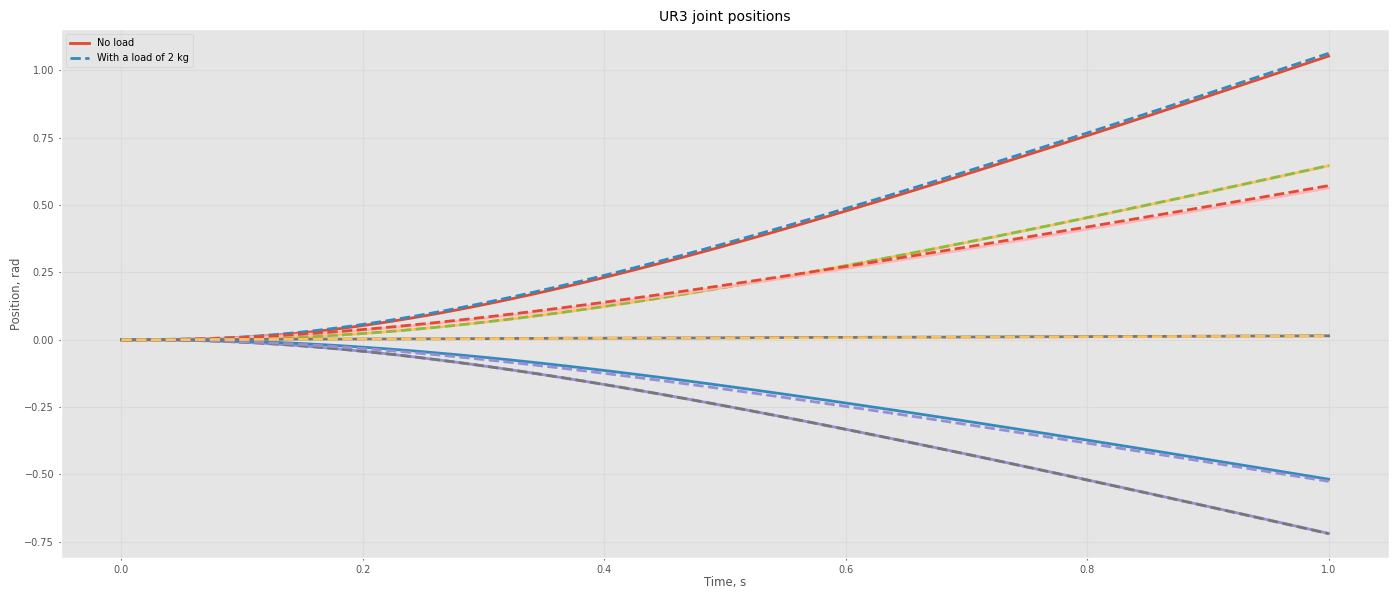

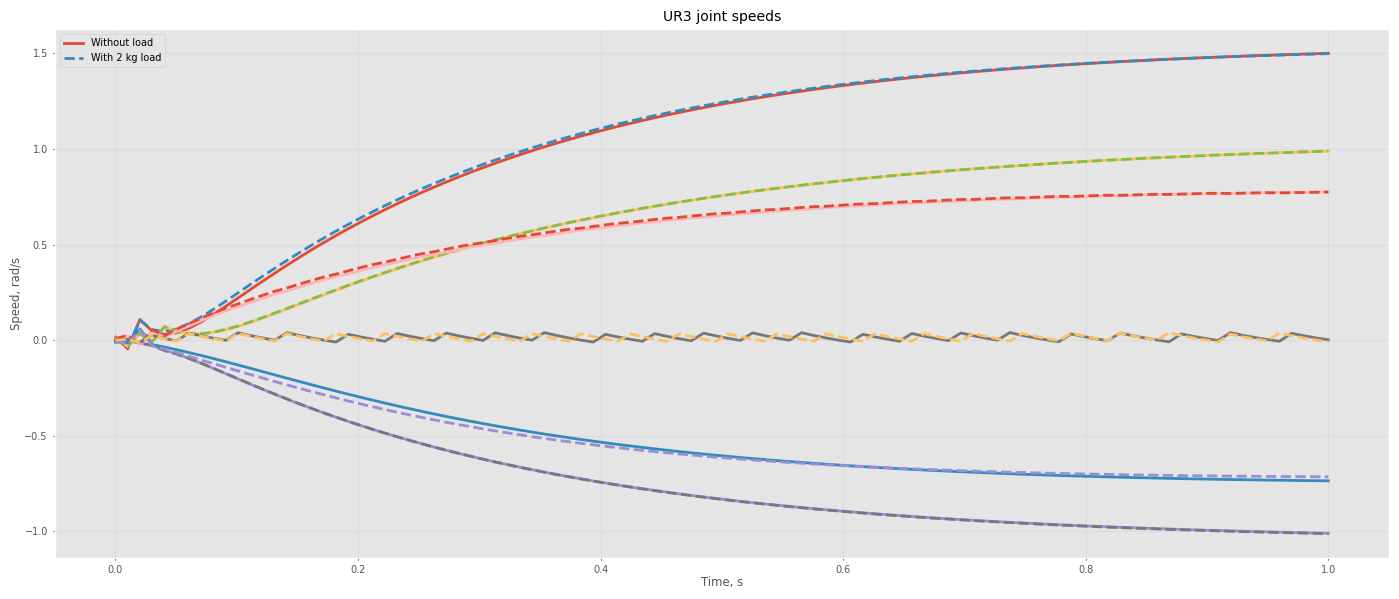

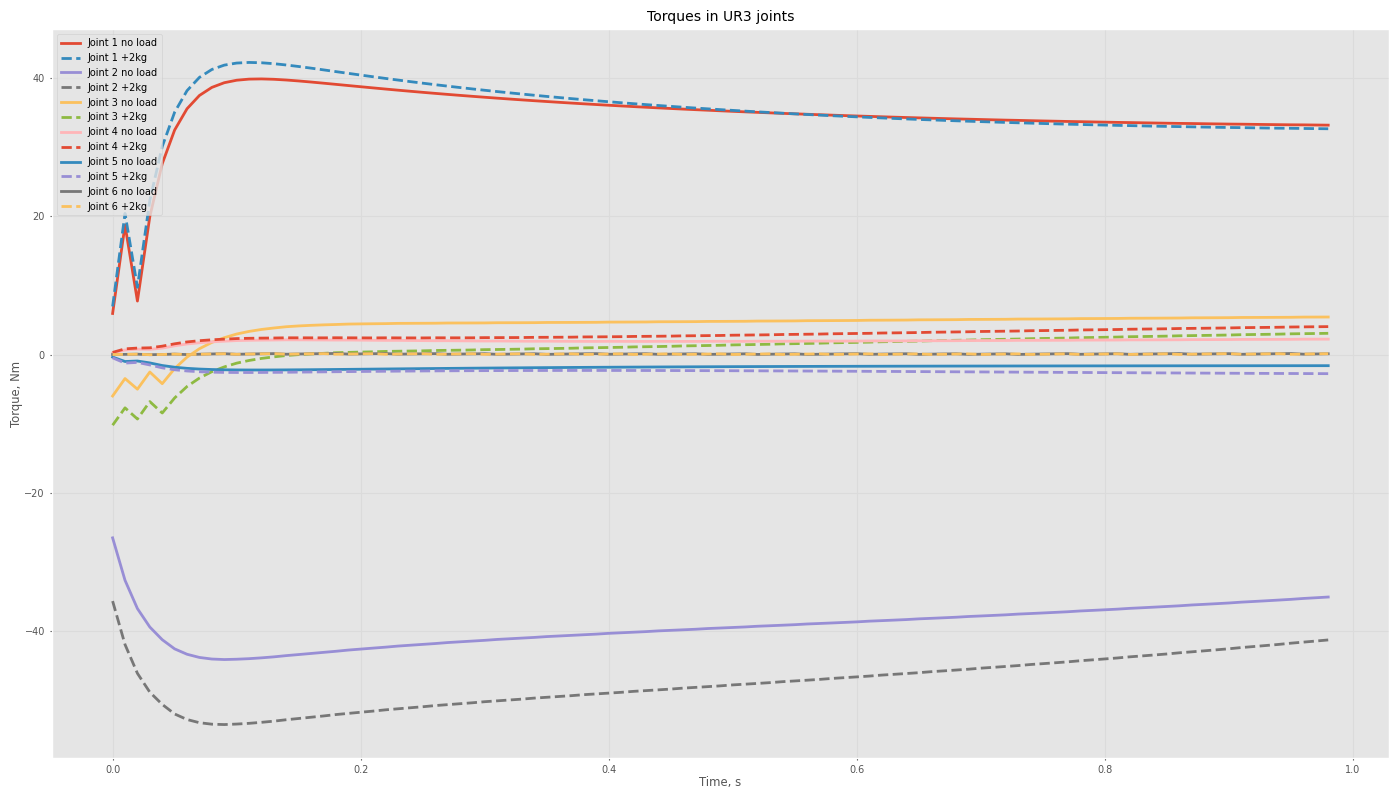

In [66]:
# No load
robot = create_ur3_robot()
q_hist, qd_hist, tau_hist = simulate(robot, traj)
# With a load of 2 kg
robot_p = create_ur3_robot()
robot_p.links[-1].m += 2
q_hist_p, qd_hist_p, tau_hist_p = simulate(robot_p, traj)

# Generating a time vector
dt = 0.01
time = np.linspace(0, len(q_hist)*dt, len(q_hist))

joint_names = [f'Joint {i+1}' for i in range(6)]

# 1. Graphs of joint positions
plt.figure(figsize=(14, 6))
for i in range(6):
    plt.plot(time, q_hist[:, i], linewidth=2, label=f'{joint_names[i]} No load' if i == 0 else None)
    plt.plot(time, q_hist_p[:, i], '--', linewidth=2, label=f'{joint_names[i]} With a load of 2 kg' if i == 0 else None)
plt.title('UR3 joint positions')
plt.xlabel('Time, s')
plt.ylabel('Position, rad')
plt.legend(['No load', 'With a load of 2 kg'])
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Graphs of joint speeds
plt.figure(figsize=(14, 6))
for i in range(6):
    plt.plot(time, qd_hist[:, i], linewidth=2, label=f'{joint_names[i]} without load' if i == 0 else None)
    plt.plot(time, qd_hist_p[:, i], '--', linewidth=2, label=f'{joint_names[i]} +2kg' if i == 0 else None)
plt.title('UR3 joint speeds')
plt.xlabel('Time, s')
plt.ylabel('Speed, rad/s')
plt.legend(['Without load', 'With 2 kg load'])
plt.grid(True)
plt.tight_layout()
plt.show()

time = np.linspace(0, (len(tau_hist)-1)*dt, len(tau_hist))
# 3. Graphs of torques in joints
plt.figure(figsize=(14, 8))
for i in range(6):
    plt.plot(time, tau_hist[:, i], linewidth=2, label=f'{joint_names[i]} no load')
    plt.plot(time, tau_hist_p[:, i], '--', linewidth=2, label=f'{joint_names[i]} +2kg')
plt.title('Torques in UR3 joints')
plt.xlabel('Time, s')
plt.ylabel('Torque, Nm')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

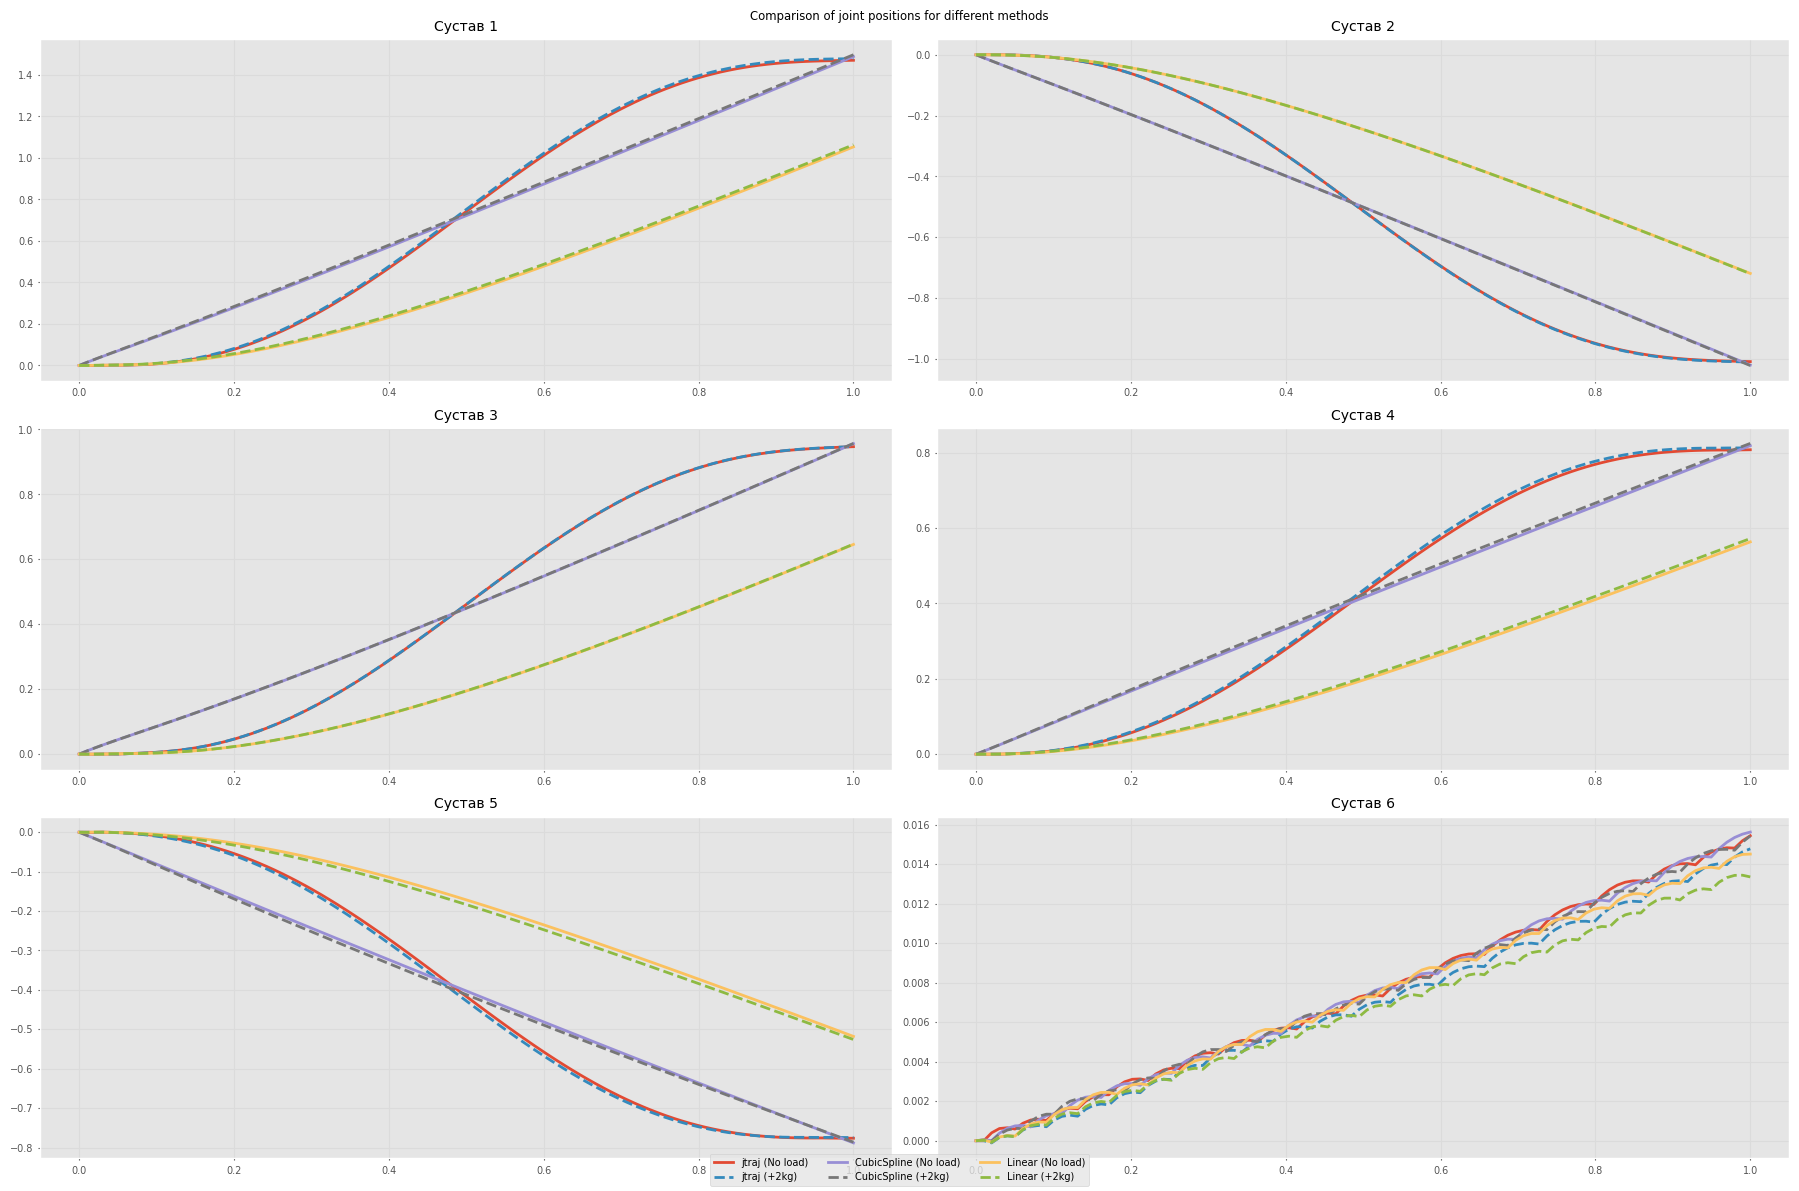

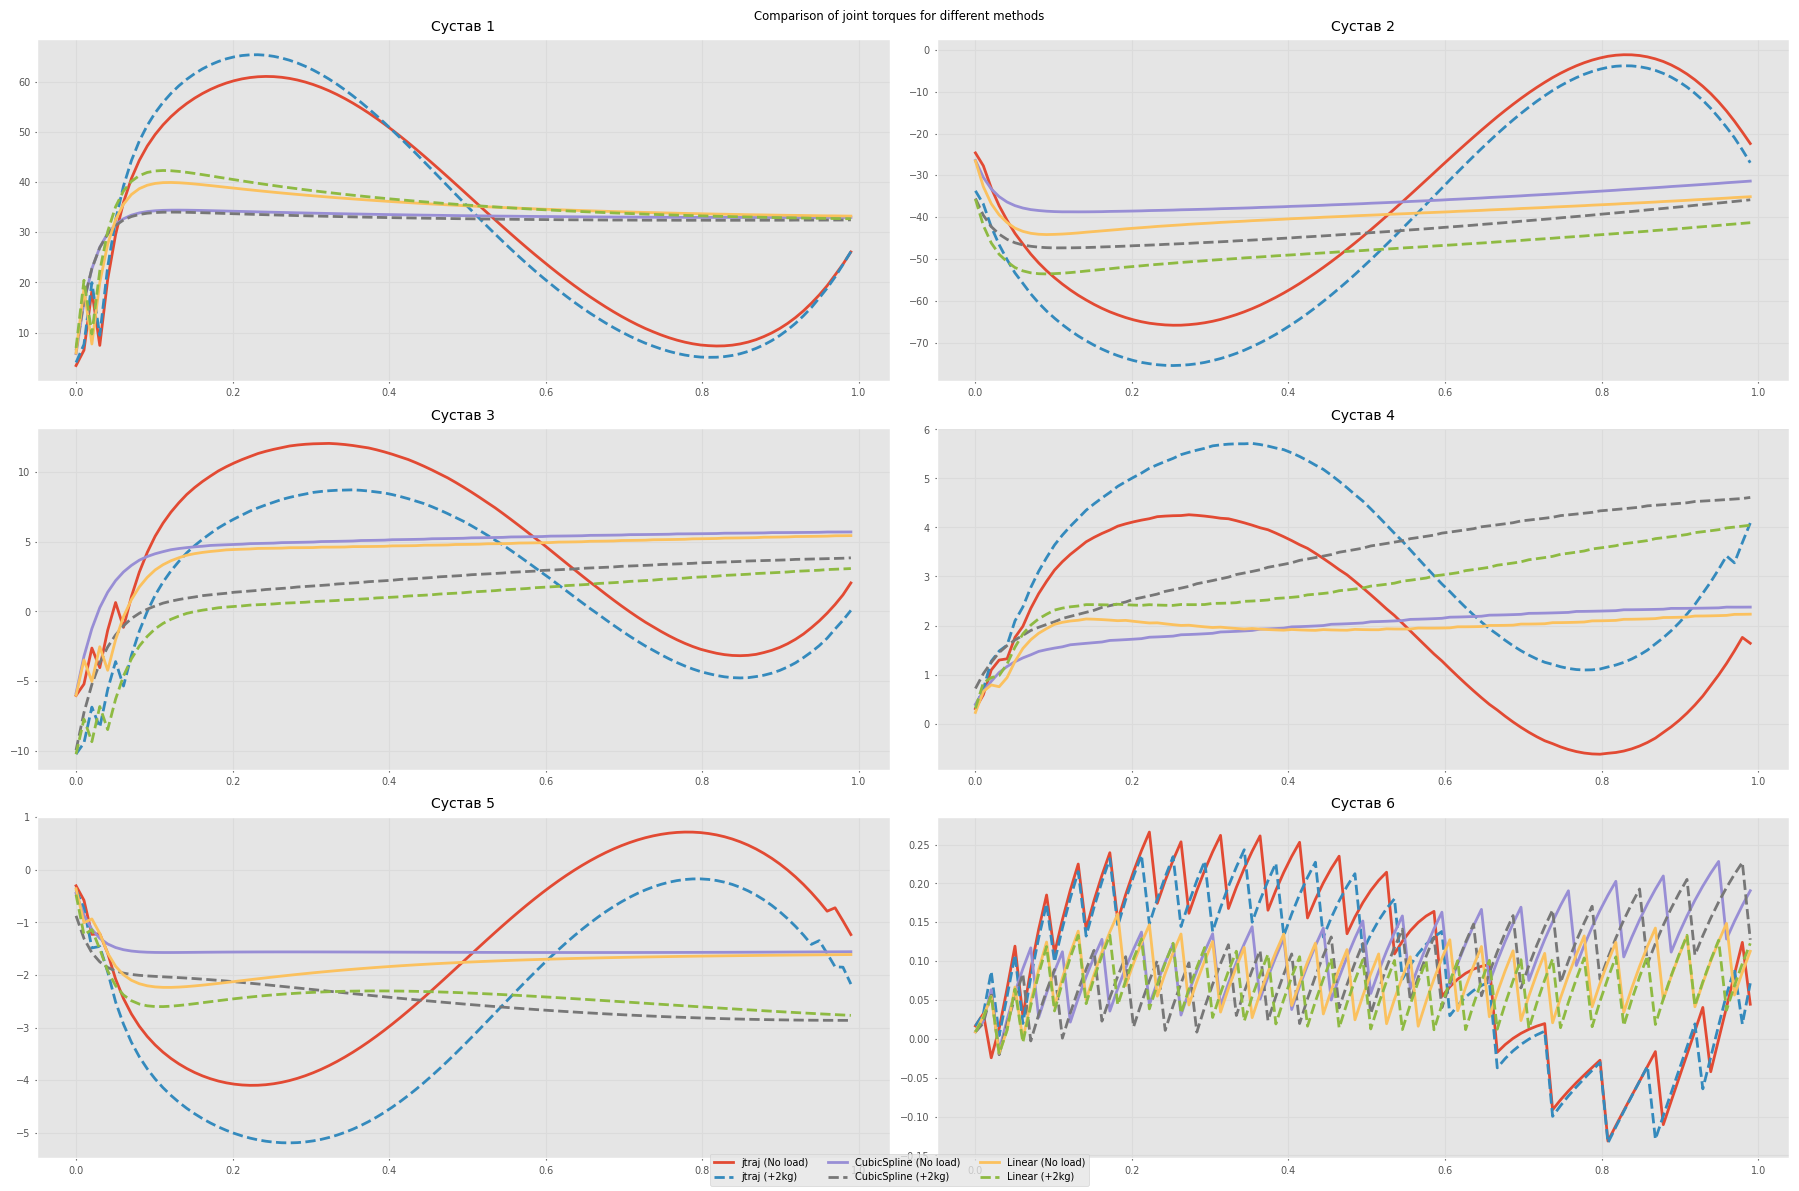

In [68]:
# Time vector generation
dt = 0.01
joint_names = [f'Joint {i+1}' for i in range(6)]

# Creating shapes for comparing methods
def plot_comparison(results, dt=0.01):
    # Comparison of positions
    fig, axs = plt.subplots(3, 2, figsize=(18, 12))
    for method in results:
        time = np.linspace(0, len(results[method]['q'])*dt, len(results[method]['q']))
        for i in range(6):
            row = i // 2
            col = i % 2
            axs[row, col].plot(time, results[method]['q'][:,i],  linewidth=2,
                             label=f'{method} (No load)' if i==0 else None)
            axs[row, col].plot(time, results[method]['q_p'][:,i], '--', linewidth=2, 
                             label=f'{method} (+2kg)' if i==0 else None)
            axs[row, col].set_title(f'Сустав {i+1}')
            axs[row, col].grid(True)
    plt.suptitle('Comparison of joint positions for different methods')
    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3)
    plt.tight_layout()
    
    # Comparison of torques
    fig, axs = plt.subplots(3, 2, figsize=(18, 12))
    for method in results:
        time = np.linspace(0, len(results[method]['tau'])*dt, len(results[method]['tau']))
        for i in range(6):
            row = i // 2
            col = i % 2
            axs[row, col].plot(time, results[method]['tau'][:,i],  linewidth=2,
                             label=f'{method} (No load)' if i==0 else None)
            axs[row, col].plot(time, results[method]['tau_p'][:,i], '--',  linewidth=2,
                             label=f'{method} (+2kg)' if i==0 else None)
            axs[row, col].set_title(f'Сустав {i+1}')
            axs[row, col].grid(True)
    plt.suptitle('Comparison of joint torques for different methods')
    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3)
    plt.tight_layout()

plot_comparison(results)